# BG2 model with arky-pallidal connections

## 2016-09-07

This adds a arky-pallidal connections rather like those in Alex B's paper.

In [10]:
# Spike Threshold parameters
snr_spike_thresh = -15
stn_spike_thresh = -15
gpe_spike_thresh = 0
d1_spike_thresh = 0
d2_spike_thresh = 0

import sys
import os

def run_bg1_model (expt=0):
    sys.path.append("../analysis")
    modeldir = '/home/seb/izhibg/GPR_Izhikevich/bg2';
    spineml2brahms ='/home/seb/src/SpineML_2_BRAHMS';
    spinemlcmd = '/bin/bash -c "pushd '+spineml2brahms+' && '+\
                 'LD_LIBRARY_PATH=\"\" ./convert_script_s2b -m '+modeldir+' -e'+\
                 `expt`+'; popd"';
    os.system(spinemlcmd);
    
# Compare spiking rate in channels
def channel_spiking (population_name, spike_thresh, start_ms, end_ms, start_channel, end_channel):

    # Make sure we have access to the load_sc_data and firing_rate functions
    import sys
    sys.path.append("../analysis")
    import load_sc_data as lsd
    import firing_rate as fr
    # Load data from SpineML_2_BRAHMS
    filepath = '/home/seb/src/SpineML_2_BRAHMS/temp/log/'+population_name+'_v_log.bin';
    V, count, t, nn, dt = lsd.load_sc_data(filepath)

    rates = []
    ratetot = 0
    numanalysed = 0
    
    if end_channel >= nn:
        print "end_channel =",end_channel,">= nn =",nn
    
    for i in range (start_channel,end_channel):
        rate, isiRate = fr.firing_rate2(V[i],(end_ms-start_ms),dt,spike_thresh,start_ms)
        rates.append(rate)
        ratetot = ratetot + rate;
        numanalysed = numanalysed + 1
    
    return float(ratetot)/numanalysed

## Here's the steady state behaviour with background input

In [16]:
expt = 1 # This is the "Steady state with background" expt
print 'Running bg2 model steady state experiment',expt
run_bg1_model (expt)
print 'Done.'

print '\n\'Steady state (with background input)\' results\n------------------'
r = channel_spiking('D1_MSN', d1_spike_thresh, 300, 800, 0, 19)
print 'D1 mean rate [60]: ', r,'spikes/s'
r = channel_spiking('D2_MSN', d2_spike_thresh, 300, 800, 0, 19)
print 'D2 mean rate [60]: ', r,'spikes/s'
r = channel_spiking('STN', stn_spike_thresh, 300, 800, 0, 19)
print 'STN mean rate [?]: ', r,'spikes/s'
r = channel_spiking('GPe', gpe_spike_thresh, 300, 800, 0, 19)
print 'GPe mean rate [?]: ', r,'spikes/s'
r = channel_spiking('GPi', snr_spike_thresh, 300, 800, 0, 19)
print 'SNr mean rate [25]: ', r,'spikes/s'

Running bg2 model steady state experiment 1
Done.

'Steady state (with background input)' results
------------------
D1 mean rate [60]:  45.6842105263 spikes/s
D2 mean rate [60]:  35.1578947368 spikes/s
STN mean rate [?]:  81.7894736842 spikes/s
GPe mean rate [?]:  311.052631579 spikes/s
SNr mean rate [25]:  31.4736842105 spikes/s


## Here's visualisation of the impulse response 

In [51]:
# Visualisation of mean firing rates from bg1 simulation, with and without sigmoid.
import numpy as np

def moving_average(a, n=3) :
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

# Graph the data. Sub-called by vis_data
def graph_data (bin_edges1, fr_sigI, logfile):
    %matplotlib inline
    import matplotlib.pyplot as plt
    plt.figure(figsize=(10,8))

    plt.plot (bin_edges1[0:-1],fr_sigI[0,:], '--', color='r', marker='o', label='Ch0', linewidth=3)
    plt.plot (bin_edges1[0:-1],fr_sigI[1,:], '--',  color='b', marker='o', label='Ch1', linewidth=3)
    plt.plot (bin_edges1[0:-1],fr_sigI[2,:], '--',  color='g', marker='o', label='Ch2', linewidth=3)

    plt.legend(loc='best',fontsize=14)

    plt.xlabel('t (ms)',fontsize=24);
    
    from matplotlib import rc
    plt.ylabel('mean neuronal firing rate (s$^{-1}$)',fontsize=24);
    plt.tick_params(axis='x', labelsize=24, pad=10)
    plt.tick_params(axis='y', labelsize=24, pad=10)
    
    plt.title(logfile)

    graphdir = '/home/seb/izhibg/GPR_Izhikevich/labbook/'

    filename = logfile.replace(' ','_')
    plt.savefig('{0}{1}.svg'.format(graphdir, filename))
    
    plt.show()

# Read & precompute the data. Sub-called by vis_data and compute_decision
def read_data (logdir1, logfile):
    logpath = logdir1 + logfile
    # sl_sigI is two columns, times and spike index
    sl_sigI = np.genfromtxt (logpath, delimiter=',')
    
    return sl_sigI

# Histogram the data lumping all 20 neurons per channel
def compute_data (sl_sigI):

    ch1idx_sigI  = (sl_sigI[:,1] < 20)
    ch2idx_sigI  = (sl_sigI[:,1] < 40) & (sl_sigI[:,1] > 19)
    ch3idx_sigI  = (sl_sigI[:,1] < 60) & (sl_sigI[:,1] > 39)
    
    # Give our histograms 20 bins.
    numbins = 80

    #print sl_sigI
    
    ch1fr, bin_edges1 = np.histogram (sl_sigI[ch1idx_sigI,0], numbins)
    ch2fr, bin_edges2 = np.histogram (sl_sigI[ch2idx_sigI,0], numbins)
    ch3fr, bin_edges3 = np.histogram (sl_sigI[ch3idx_sigI,0], numbins)
    fr_sigI = np.vstack((ch1fr,ch2fr,ch3fr))
    allfr_sigI, bin_edgesall = np.histogram (sl_sigI[:,0], numbins)

    # There are 20 neurons per channel in this model, 60 total
    neuronsPerChan = 20
    num_channels_used = 3 # We only take data from first 3 channels!
    neuronsPerInvestigation = neuronsPerChan * num_channels_used

    simlength_ms = 2000    
    
    # Scale the firing rates
    bintime = simlength_ms / numbins;
    fr_sigI  = (fr_sigI) * 1000 / (bintime * neuronsPerChan)
    allfr_sigI = (allfr_sigI * 1000) / (bintime * neuronsPerInvestigation)

    return bin_edges1, fr_sigI

# Histogram the data for each neuron (expt should have run 100 times)
def compute_data_indiv (sl_sigI):

    #ch1idx_sigI  = (sl_sigI[:,1] < 20)
    #ch2idx_sigI  = (sl_sigI[:,1] < 40) & (sl_sigI[:,1] > 19)
    #ch3idx_sigI  = (sl_sigI[:,1] < 60) & (sl_sigI[:,1] > 39)
    
    ch1idx_sigI  = sl_sigI[:,1] == 12
    ch2idx_sigI  = sl_sigI[:,1] == 22
    ch3idx_sigI  = sl_sigI[:,1] == 45
    
    #for i in range(0,59):
    
    # Give our histograms 20 bins.
    numbins = 800

    #print sl_sigI
    
    ch1fr, bin_edges1 = np.histogram (sl_sigI[ch1idx_sigI,0], numbins)
    ch2fr, bin_edges2 = np.histogram (sl_sigI[ch2idx_sigI,0], numbins)
    ch3fr, bin_edges3 = np.histogram (sl_sigI[ch3idx_sigI,0], numbins)
    fr_sigI = np.vstack((ch1fr,ch2fr,ch3fr))
    allfr_sigI, bin_edgesall = np.histogram (sl_sigI[:,0], numbins)

    # There are 20 neurons per channel in this model, 60 total
    neuronsPerChan = 1
    num_channels_used = 3 # We only take data from first 3 channels!
    neuronsPerInvestigation = neuronsPerChan * num_channels_used

    simlength_ms = 2000    
    
    # Scale the firing rates
    bintime = simlength_ms / numbins;
    fr_sigI  = (fr_sigI) * 1000 / (bintime * neuronsPerChan)
    allfr_sigI = (allfr_sigI * 1000) / (bintime * neuronsPerInvestigation)

    return bin_edges1, fr_sigI

# Visualise the given logfile (the log of a single population) for the two
# simulation outputs in logdir1 and logdir2. Assumptions about what kind of
# data is in logdir1 and logdir2 are made.
def vis_data (logdir1, logfile):
    sl_sigI = read_data (logdir1, logfile)
    bin_edges1, fr_sigI = compute_data_indiv (sl_sigI)
    graph_data (bin_edges1, fr_sigI, logfile)
## end visualisation function

def vis_much_data (sl_sigI):    
    bin_edges1, fr_sigI = compute_data_indiv (sl_sigI)
    graph_data (bin_edges1, fr_sigI, logfile)


## Visualise the impulse response

Response of BG1TC model to impulse input.


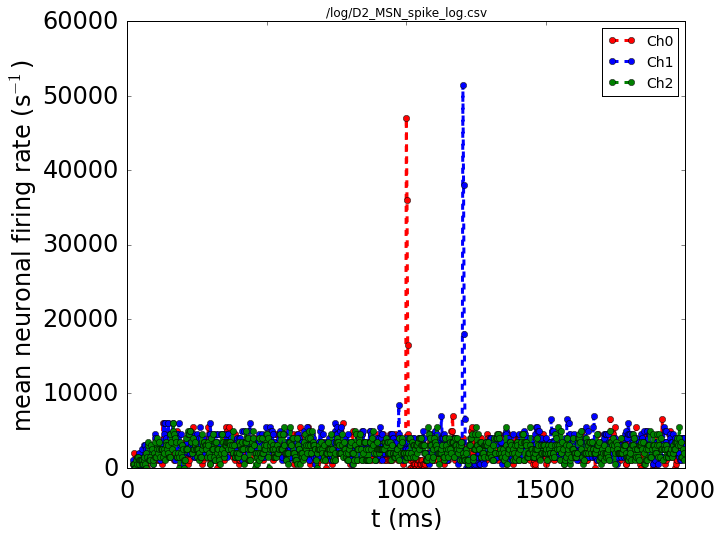

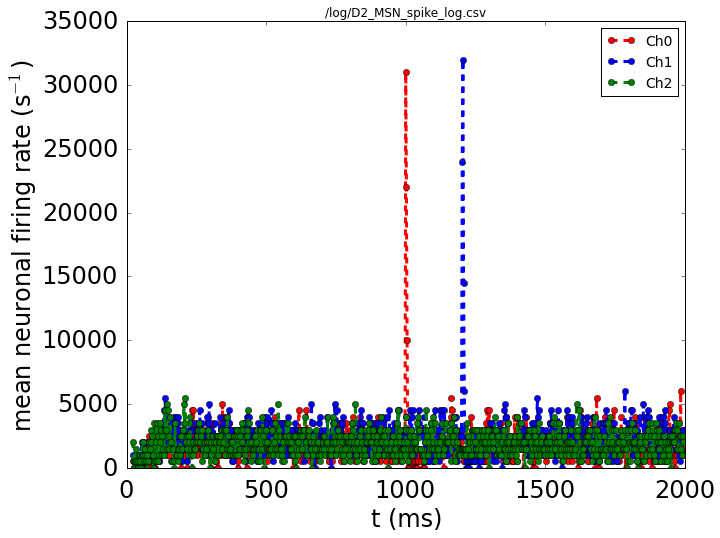

In [52]:
# Set to 0 if you're messing with the program and you already computed the simulation:
require_recompute = 1;

# Where is the data going to end up?
logdir1 = '/home/seb/tmp/impulse'

# Import update_bg1_model_xml.py
##import sys
##sys.path.append("../analysis")
#import update_bg1_model_xml as bg1update

print ('Response of BG1TC model to impulse input.')

# Where's the source model?
modeldir = '/home/seb/izhibg/GPR_Izhikevich/bg2'
expt = 3

import os
spineml2brahms ='/home/seb/src/SpineML_2_BRAHMS'
spinemlcmd = '/bin/bash -c "pushd '+spineml2brahms+' && '+\
             'LD_LIBRARY_PATH=\"\" ./convert_script_s2b -m '+modeldir+' -e'+\
             `expt` + ' -o ' + `logdir1` + ' ; popd"';

sl_D1 = np.ndarray((0,2))
sl_D2 = np.ndarray((0,2))
sl_STN = np.ndarray((0,2))
sl_GPe = np.ndarray((0,2))
sl_GPi = np.ndarray((0,2))

if require_recompute:
    for i in range(0,50):
        os.system(spinemlcmd);

        # Build arrays for populations of interest
        logfile = '/log/D1_MSN_spike_log.csv'
        sl_D1_one = read_data (logdir1, logfile)
        sl_D1 = np.vstack((sl_D1, sl_D1_one))

        logfile = '/log/D2_MSN_spike_log.csv'
        sl_D2_one = read_data (logdir1, logfile)
        sl_D2 = np.vstack((sl_D2, sl_D2_one))


vis_much_data (sl_D1)
vis_much_data (sl_D2)
#vis_much_data (sl_STN)
#vis_much_data (sl_GPe)
#vis_much_data (sl_GPi)


** 2016-09-06 **

I've got a problem with this TC loop, which is that given stochastic connections within each of the three channels, I have each of the TC loop channels having different responses - that is channel 3 stabilises at 500 spikes/s, but ch2 is only about 280 and ch3 is less still. If I re-generate the connections from Thalamus to cortex or vice versa, then the ordering changes, so it's all about the luck of the draw - if a channel gets regenerated with a few more connections, then it may produce a higher firing rate. This is not what I want; I want the channels to produce similar rates for background input.

A possible solution is to have 3 separate cortex populations, and tweak the weights from thalamus to the individual populations so that the firing rates stabilise to a similar rate. Simpler would be to have 3 different backgrounds that compensate for the wiring.

I found one problem was that I had different weights in the 2 synapses for the spike input -> Cortex connections.

Once that was fixed, I was surprised to find that I had to turn one of the channels input spike rate down to 3 compared with 5 for the other two channels. This means that Ch1 rises slower than the other two, but reaches the same mean equilibrium value. Re-generating the connectivity can change which channel is strongest (with all inputs set to 5). So I think to use a TC loop like this, I will need some sort of adaptation to get the channels to run up to the same equilibrium firing for background operation.

I think I'll try to fix this by changing weights from Spikes to Cortex.